# Amazon Fine Food Reviews Analysis

Title: Making predictions and doing exploratory analysis over Amazon Fine Food Reviews dataset <br>

Author: Shashank Ramesh

Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

Relevant Information: The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>


Description: The purpose of this task is to do an in-depth analysis of the fine food reviews given by the customers at amazon.com and find relations between the attributes, extract relevant facts and also make a prediction model to predict given a review for it to be positive or negetive.


Number of Instances: 568,454<br>
Number of Attributes: 10 (including the class attribute)

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review




## 1. Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('database.sqlite') #reading from the database file

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) #filtering only positive and negative reviews i.e. not taking into consideration reviews with Score=3

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

Score = filtered_data['Score']
Score = Score.map(partition) #changing reviews with score less than 3 to be positive and vice-versa
filtered_data['Score'] = Score

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data

(525814, 10)

# 2 Analysis of the data

## 2.1 Deduplication

It is observed on doing analysis (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. 

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

It can be seen above that we have used subset={"UserId","ProfileName","Time","Text"} and not included parameters like HelpfulnessNumerator,HelpfulnessDenominator,Score etc. as on doing so we found entries like the one below which had different values of the above parameters but the same timestamp user and review text hence chose those parameters for deduplication according to the basic logic that one customer cannot type-in multiple reviews with different Summaries at exactly at the same timestamp (i.e. within 1ms)

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="A1R6PBUJB8LBGC"
ORDER BY ProductID
""", con)
display[:3]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,435043,B000HDJXLW,A1R6PBUJB8LBGC,"Stretch ""Stretch""",2,7,1,1266451200,Agreed? No BPA!,Muir Glen cans are lined in plastic and leach ...
1,459852,B000LKTZNM,A1R6PBUJB8LBGC,"Stretch ""Stretch""",2,2,1,1266451200,Not without BPA,Muir Glen cans are lined in plastic and leach ...
2,456867,B000LKTZSM,A1R6PBUJB8LBGC,"Stretch ""Stretch""",10,13,1,1266451200,Organic endocrine disruptor!?,Muir Glen cans are lined in plastic and leach ...


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
final=final[final.Text!='&#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1079;&#1072;&#1082;&#1072;&#1079;&#1072;&#1090;&#1100; &#1101;&#1090;&#1080; &#1078;&#1077;&#1083;&#1072;&#1090;&#1080;&#1085;&#1082;&#1080;, &#1090;.&#1082;. &#1076;&#1086;&#1095;&#1082;&#1072; &#1087;&#1086;&#1096;&#1083;&#1072; &#1074; &#1096;&#1082;&#1086;&#1083;&#1091; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090; &#1089;&#1083;&#1072;&#1076;&#1086;&#1089;&#1090;&#1080;. &#1054;&#1095;&#1077;&#1085;&#1100; &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;. &#1050;&#1072;&#1082; &#1088;&#1072;&#1079; &#1089;&#1090;&#1086;&#1083;&#1100;&#1082;&#1086; &#1082;&#1086;&#1085;&#1092;&#1077;&#1090;, &#1082;&#1072;&#1082; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090;&#1089;&#1103;, &#1095;&#1090;&#1086;&#1073;&#1099; &#1089;&#1100;&#1077;&#1089;&#1090;&#1100; &#1080;&#1093; &#1079;&#1072; &#1087;&#1077;&#1088;&#1077;&#1084;&#1077;&#1085;&#1091;.']
final=final[final.Text!='T H I S  C H O C O L A T E  I S  A D D I C T I O N  I  C A N \'T  S T O P  E A T I N G  I T T T T T']
final=final[final.Text!='v e r y g o o d v e r y g o o d v e r y g o o d v e r y g o o d']
final=final[final.Text!='r8gtq9hrtp  d s h jnrgisdxc f j h xd d jn sd j g z  f j hg  xzz d d fg f g g h jk l l  iyt r wq s gv  hjk j g 9hpt fg g']

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
final.shape

(364167, 10)

## 2.2 Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = ' '.join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [16]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


## 2.3 Words Analysis

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [ ]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(5))
print("Most Common Negative Words : ",freq_dist_negative.most_common(5))

Let's see what are the number of unique words describing positive and negative reviews

In [ ]:
unique_positive_words=list(set(all_positive_words))
unique_negative_words=list(set(all_negative_words))
print("Number of unique words describing positive sentiment : ",len(unique_positive_words))
print("Number of unique words describing positive sentiment : ",len(unique_negative_words))

In [ ]:
all_words=unique_positive_words + unique_negative_words
unique_words=set(all_words)
print("Number of unique words used in the reviews : ",len(unique_words))

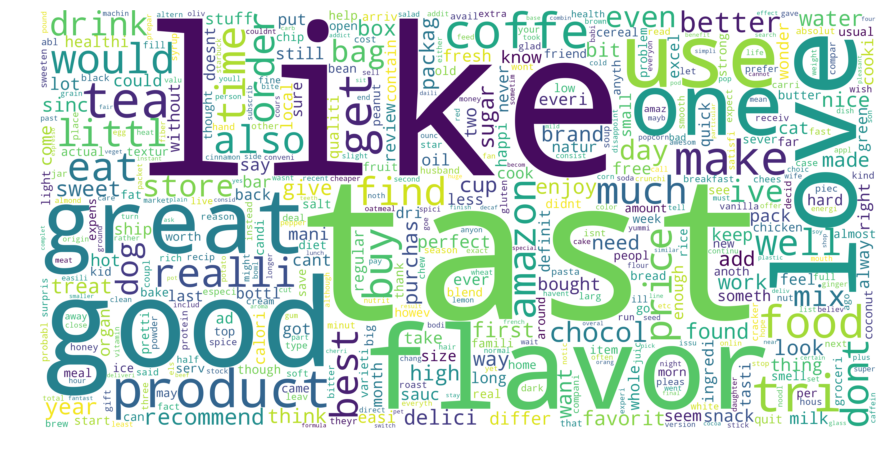

In [21]:
#Visualising the positive words in a wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=4000,height=2000,max_words=500,background_color="white")
wordcloud.generate_from_frequencies(frequencies=freq_dist_positive)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

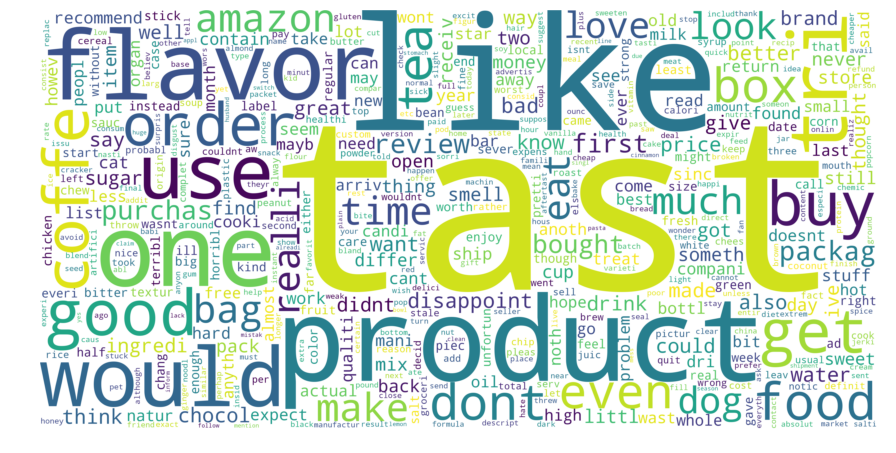

In [68]:
#Visualising the negative words in a wordcloud
wordcloud = WordCloud(width=4000,height=2000,max_words=500,background_color="white")
wordcloud.generate_from_frequencies(frequencies=freq_dist_negative)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc.
Lets now visualise the words which are exclusively present only in positive or negative reviews

In [18]:
#extracting the words that are only present in positive or negative reviews 
common_positive_words=[w for (w,x) in freq_dist_positive.most_common()]
common_negative_words=[w for (w,x) in freq_dist_negative.most_common()]
only_positive=set(common_positive_words).difference(set(common_negative_words))
only_negative=set(common_negative_words).difference(set(common_positive_words))

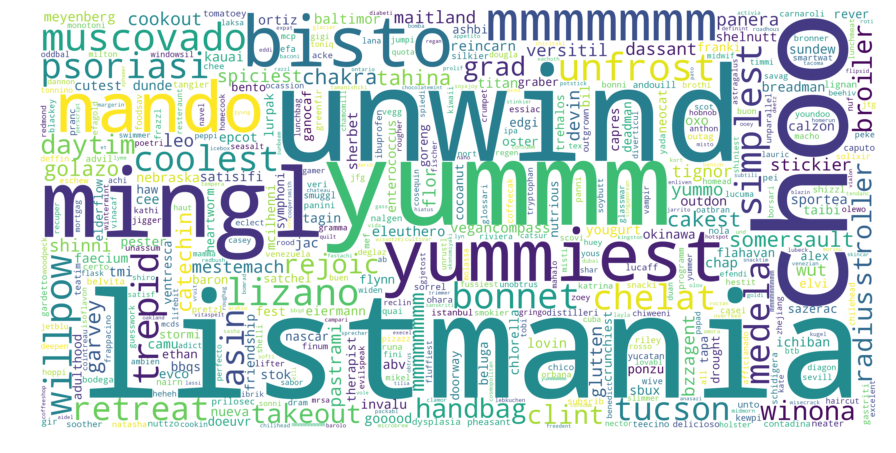

In [22]:
#visualising the words that are only present in positive reviews in wordclouds 
pos_data={}
for i in only_positive:
    pos_data[i] = freq_dist_positive[i]
wordcloud = WordCloud(width=4000,height=2000,max_words=500,background_color="white")
wordcloud.generate_from_frequencies(frequencies=pos_data)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

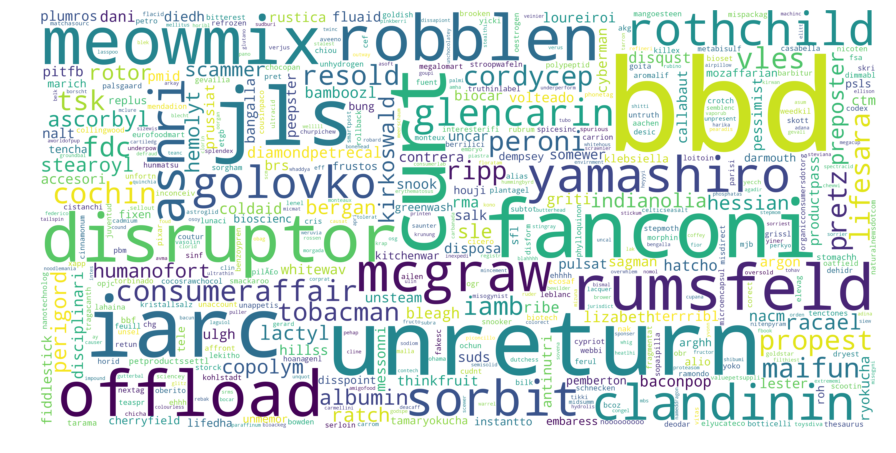

In [23]:
#visualising the words that are only present in negative reviews in wordclouds 
neg_data={}
for i in only_negative:
    neg_data[i] = freq_dist_negative[i]
wordcloud = WordCloud(width=4000,height=2000,max_words=500,background_color="white")
wordcloud.generate_from_frequencies(frequencies=neg_data)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Before we proceed to the next analysis stage lets add a column with the word count of the legitimate words present in our review text as shown below 

In [17]:
#adding a column named WordCount which tells us the number of legitimate words in the review text
final['WordCount']= final['CleanedText'].values
final['WordCount'] = final['WordCount'].apply(lambda i: len(i.split()))

In [ ]:
#Displaying WordCount column below
final_train=final.head(255000)

In [22]:
#We also save this format of the final data along with the values in another SQLite table for easy querrying for analysis later
conn = sqlite3.connect('test.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [494]:
conn = sqlite3.connect('train.sqlite')
c=conn.cursor()
conn.text_factory = str
final_train.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [20]:
conn = sqlite3.connect('train.sqlite')

## 2.3 Time Analysis

In this section we will be analysing the imapact of time on the reviews

In [62]:
t_analysis= pd.read_sql_query("""
SELECT *
FROM Reviews
ORDER BY Time
""", conn)

In [63]:
t_analysis.head(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,35


In [64]:
t_analysis.tail(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
364172,355171,384161,B000EVWQZW,A2PCNXBSKCABG5,Whit,0,0,positive,1351209600,Versatile Mix,This mix makes a good bread or can also be use...,mix make good bread also use make pop over nea...,19


<b>Observation:-</b>From the above two cells it is seen that the first timestamp is 939340800 corresponsonding to 8th October 1999, 05:30:00 and last timestamp is 1351209600 corresponding to 26th October 2012, 05:30:00

As we know that the period span covered in the reviews are from the year 1999 to 2012 hence now we shall see the plots of<br> 
1. Number of Reviews recieved w.r.t. time
2. Number of Unique Products reviewed w.r.t. time
3. Number of Unique Users reviewing w.r.t. time

In [65]:
#function to help us convert timestamp to date
import datetime
def getDate(stamp):
    return datetime.datetime.fromtimestamp(stamp).strftime('%Y')

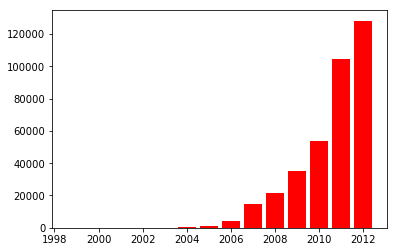

In [66]:
#Plot to see how the number of reviews change w.r.t. time
countR={}
for i in t_analysis['Time']:
    d=getDate(i)
    d=int(d)
    if(countR.has_key(d)):
        countR[d]=countR[d]+1
    else:
        countR[d]=1
plt.bar(countR.keys(), countR.values(), color='r')
plt.show()

In [68]:
i=900000000
x1=[]
y1=[]
x2=[]
y2=[]
while i<1360000000:
    x1.append(i)
    x2.append(i)
    i+=10000000
    y1.append((t_analysis[(t_analysis.Time < i) & (t_analysis.Score=='positive') ]).size/13)
    y2.append((t_analysis[(t_analysis.Time < i) & (t_analysis.Score=='negative') ]).size/13)

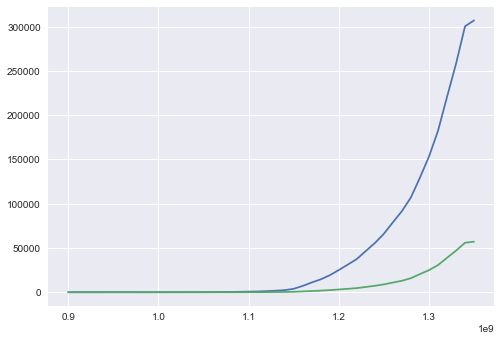

In [69]:
#plot showing variation of positive and negetive reviews with time
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(x1,y1,x2,y2)
plt.show()

<b>Observation:-</b> From the above plot it is clear that customer satisfaction with the quality of Amazon Fine Foods has kept increasing which is shown by the exponential rise in the number of positive reviews and not that much for the negative reviews.

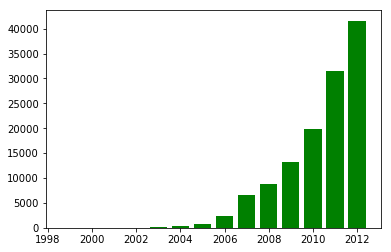

In [37]:
#Plot to see how the number of products reviewed change w.r.t. time
countP={}
time=t_analysis['Time'].values
year=1999
pl=[]
j=0
for i in t_analysis['ProductId']:
    d=getDate(time[j])
    j+=1
    d=int(d)
    if(d!=year):
        pl=list(set(pl))
        countP[year]=len(pl)
        year=d
        pl=[]
        pl.append(i)
    else:
        pl.append(i)
pl=list(set(pl))
countP[d]=len(pl)
plt.bar(countP.keys(), countP.values(), color='g')
plt.show()

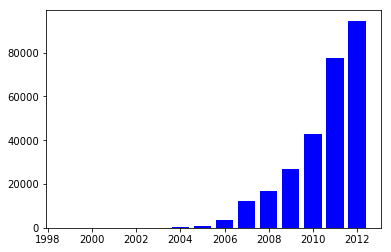

In [38]:
#Plot to see how the number of users reviewing change w.r.t. time
countU={}
time=t_analysis['Time'].values
year=1999
pl=[]
j=0
for i in t_analysis['UserId']:
    d=getDate(time[j])
    j+=1
    d=int(d)
    if(d!=year):
        pl=list(set(pl))
        countU[year]=len(pl)
        year=d
        pl=[]
        pl.append(i)
    else:
        pl.append(i)
pl=list(set(pl))
countU[d]=len(pl)
plt.bar(countU.keys(), countU.values(), color='b')
plt.show()

<b>Observation:-</b> It can be seen from all the plots that there is a rise between values every year showing how Amazon Fine Foods has been piercing into the masses.It is to note that there is a significant rise in values of 2010 to 2011 this tells us that maybe that the reforms or strategies used in this period has done marvels as even the customer satisfaction speaks for the same, inferred by the increasing positive reviews.

## 2.4 Ratings Analysis

In this section we'll be doing analysis based on the rating value that is positive or negative

In [303]:
RatingDetails = pd.read_sql_query("""
SELECT COUNT(Score) AS NumberOfReviews , Score
FROM Reviews
GROUP BY Score
ORDER BY COUNT(Score) desc
""", conn)
RatingDetails.set_index(RatingDetails['Score'],inplace=True)
RatingDetails['NumberOfReviews']=RatingDetails['NumberOfReviews']/364173*100
RatingDetails

,NumberOfReviews,Score
Score,,
positive,84.317893,positive
negative,15.682107,negative


<b>Observation:-</b> It can be seen from the above plot that the positive reviews constitue about ~84% of the number of reviews hence the dataset is imbalanced

In [304]:
RatingDetails = pd.read_sql_query("""
SELECT Score,COUNT(Score) AS NumberOfReviews , AVG(WordCount) AS AverageWordsUsed,AVG(HelpfulnessNumerator/HelpfulnessDenominator)*100 AS HelpfulnessDegree
FROM Reviews
GROUP BY Score
ORDER BY COUNT(Score) desc
""", conn)
RatingDetails

,Score,NumberOfReviews,AverageWordsUsed,HelpfulnessDegree
0,positive,307063,37.699925,73.720840
1,negative,57110,41.112922,30.023289


In [305]:
RatingDetails = pd.read_sql_query("""
SELECT Score, HelpfulnessNumerator, HelpfulnessDenominator,WordCount
FROM Reviews
""", conn)
RatingDetails['HelpfulnessDegree']=(RatingDetails['HelpfulnessNumerator']*1.0/RatingDetails['HelpfulnessDenominator']*1.0)*100
RatingDetails=RatingDetails[RatingDetails.HelpfulnessDegree <= 100]
RatingDetails = RatingDetails[np.isfinite(RatingDetails['HelpfulnessDegree'])]

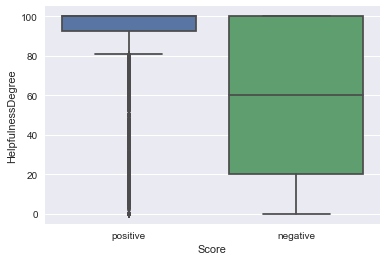

In [306]:
#plotting Score vs HelpfulnessDegree=(HelpfulnessNumerator/HelpfulnessDenominator)*100
import seaborn as sns
sns.boxplot(x='Score',y='HelpfulnessDegree', data=RatingDetails)
plt.show()

<b>Observation:-</b> From the above plot it can be inferred that positive reviews are more helpful than negative reviews as the mean of the HelpfulnessDegree for positive is way greater than that of negative reviews.

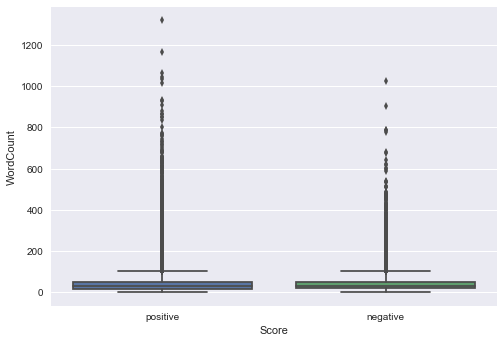

In [68]:
sns.boxplot(x='Score',y='WordCount', data=RatingDetails)
plt.show()

<b>Observation:-</b> We cannot distinguish much from the plot but the mean-line of WordCount in negative reviews seems to be a bit higher than that in the WordCount in positive reviews

In [307]:
import math
RatingDetails = pd.read_sql_query("""
SELECT Score, WordCount
FROM Reviews
""", conn)

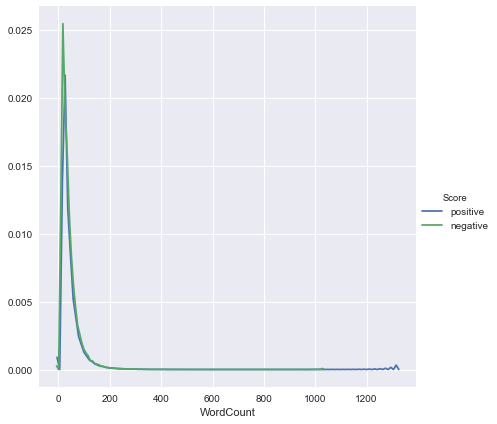

In [308]:
sns.FacetGrid(RatingDetails,hue='Score',size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

<b>Observation:-</b> It was observed that the number of words (word count) in the Reviews ( Positive,Negetive and Total) are Log-Normal distributed and hence as shown below converted each value to its log and as shown below we have a normal distribution of data.

In [309]:
RatingDetails = pd.read_sql_query("""
SELECT WordCount
FROM Reviews
""", conn)
RatingDetails['WordCount']=RatingDetails[RatingDetails.WordCount>0]
RatingDetails.WordCount = RatingDetails.WordCount.astype(float)
RatingDetails['WordCount']=RatingDetails['WordCount'].apply(lambda i: math.log(i))

In [352]:
import scipy.stats as s
s.anderson(RatingDetails['WordCount'].values, dist='norm')

AndersonResult(statistic=nan, critical_values=array([ 0.58,  0.66,  0.79,  0.92,  1.09]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

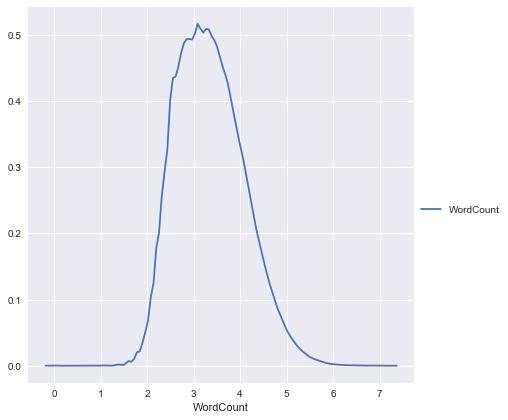

In [121]:
sns.FacetGrid(RatingDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

## 2.5 Customers Analysis

In this section we will be analysing the users customers giving the reviews to help us do so we would be adding a few new terminologies :- <br>
<b>Negativity</b> - It is a measure to see if Negative Reviews are more than Positive Reviews<br>
<b>DegreeOfPositivity</b> - It is a measure of the Number of Positive Reviews out of the Total Number Of Reviews given by a user  
<b>FrequentReviewer</b> - Is a user who has given more than 50 reviews. There are 92 such reviewers who have submitted more than 50 reviews out of 243414 unique users.

In [632]:
UserDetails = pd.read_sql_query("""
SELECT COUNT(UserId) AS NumberOfReviews,UserId, ProfileName,SUM(Score='positive') AS PositiveReviews,SUM(Score='negative') AS NegetiveReviews, AVG(HelpfulnessNumerator/HelpfulnessDenominator)*100 AS HelpfulnessDegree,COUNT(UserId)>50 AS FrequentReviewer,AVG(WordCount) AS WordsUsed,SUM(Score='negative')>SUM(Score='positive') AS Negativity  
FROM Reviews
GROUP BY UserId
ORDER BY FrequentReviewer,Negativity desc, NumberOfReviews desc
""", conn)
UserDetails[:5]

,NumberOfReviews,UserId,ProfileName,PositiveReviews,NegetiveReviews,HelpfulnessDegree,FrequentReviewer,WordsUsed,Negativity
0,49,AKZKG2Z7CNV27,BreezyPaige,15,34,60.869565,0,135.510204,1
1,46,A2TN9C5E4A0I3F,Jimmy,20,26,44.444444,0,46.847826,1
2,30,A1Z7XV6JU0EV8M,"Barbara ""Barbara""",7,23,31.578947,0,18.666667,1
3,25,A11YOTONCPRQ9S,SH,12,13,52.941176,0,35.240000,1
4,22,A2WS6FMF750EI9,"Amy Steele ""quirky mama""",9,13,42.857143,0,47.863636,1


In [633]:
UserDetails['DegreeOfPositivity']=UserDetails['PositiveReviews']*1.0/UserDetails['NumberOfReviews']*1.0
UserDetails[:5]

,NumberOfReviews,UserId,ProfileName,PositiveReviews,NegetiveReviews,HelpfulnessDegree,FrequentReviewer,WordsUsed,Negativity,DegreeOfPositivity
0,49,AKZKG2Z7CNV27,BreezyPaige,15,34,60.869565,0,135.510204,1,0.306122
1,46,A2TN9C5E4A0I3F,Jimmy,20,26,44.444444,0,46.847826,1,0.434783
2,30,A1Z7XV6JU0EV8M,"Barbara ""Barbara""",7,23,31.578947,0,18.666667,1,0.233333
3,25,A11YOTONCPRQ9S,SH,12,13,52.941176,0,35.240000,1,0.480000
4,22,A2WS6FMF750EI9,"Amy Steele ""quirky mama""",9,13,42.857143,0,47.863636,1,0.409091


In [ ]:
UserDetails = pd.read_sql_query("""
SELECT COUNT(UserId) AS NumberOfUserReviews,UserId,COUNT(UserId)>50 AS FrequentReviewer,SUM(Score='positive') AS PositiveReviews
FROM Reviews
GROUP BY UserId
ORDER BY FrequentReviewer desc
""", conn)
UserDetails[:5]

In [ ]:
UserDetails['DegreeOfPositivity']=UserDetails['PositiveReviews']*1.0/UserDetails['NumberOfUserReviews']*1.0
del UserDetails['PositiveReviews']
UserDetails[:5]

In [ ]:
conn = sqlite3.connect('errors.sqlite')
c=conn.cursor()
conn.text_factory = str
UserDetails.to_sql('Users', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

<b>Observation:-</b> It is seen from the query run above <b>(ORDER BY FrequentReviewer desc,Negativity desc)</b> that there is no Frequent Reviewer such that Negativity = 1 or where the number of negative reviews given by the Frequent Reviewer is more than the number of positive reviews.

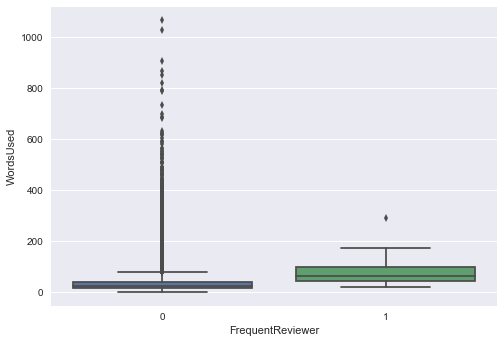

In [205]:
sns.boxplot(x='FrequentReviewer',y='WordsUsed', data=UserDetails)
plt.show()

<b>Observation:-</b> It is observed from the above plot that the  Number of Words used in reviews by Frequent Reviewers is more as compared to that in the reviews of Non-frequent customers

In [206]:
UserDetails = UserDetails[np.isfinite(UserDetails['HelpfulnessDegree'])]

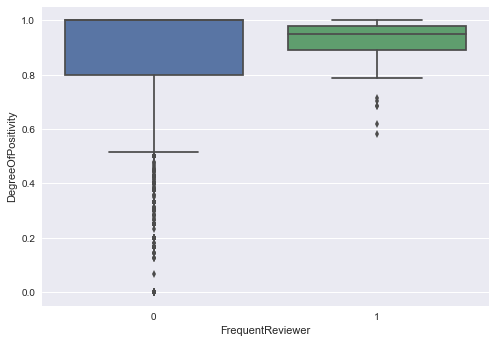

In [207]:
sns.boxplot(x='FrequentReviewer',y='DegreeOfPositivity', data=UserDetails)
plt.show()

<b>Observation:-</b> In General all users tend to write more positive reviews but in particular, Frequent Reviewers generally write a very few negetive reviews when compared to the total number of reviews given by him.

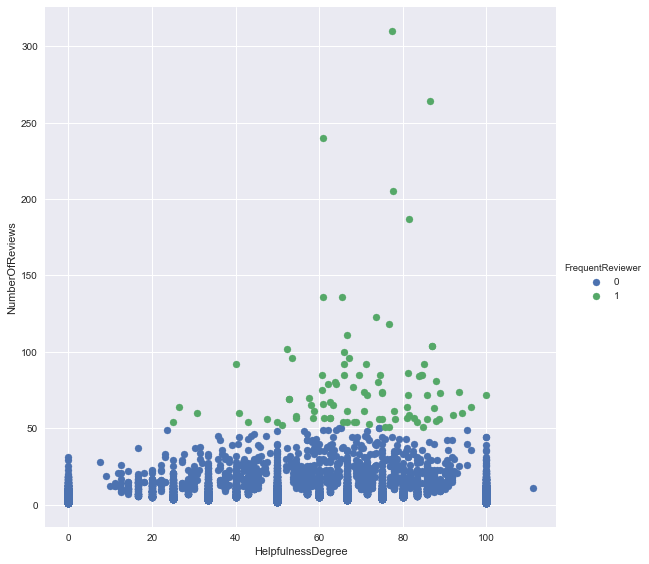

In [214]:
sns.FacetGrid(UserDetails, hue="FrequentReviewer", size=8) \
   .map(plt.scatter, "HelpfulnessDegree", "NumberOfReviews") \
   .add_legend();
plt.show();

<b>Observation:-</b> Reviews given by frequent reviewers are generally very helpful as seen in the above plot

In [316]:
UserDetails = pd.read_sql_query("""
SELECT WordCount  
FROM Reviews
WHERE UserId="A3OXHLG6DIBRW8"
""", conn)

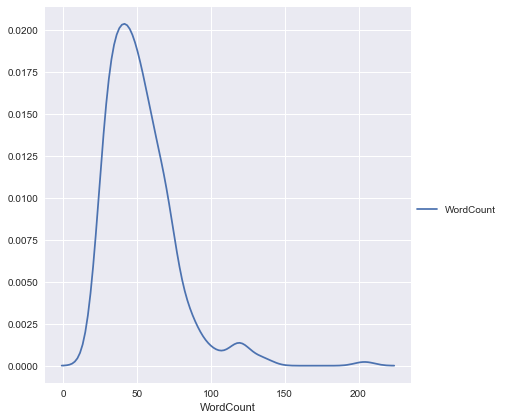

In [133]:
sns.FacetGrid(UserDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

<b>Observation:-</b> The WordCount distribution for Frequent Reviewers were taken and it was observed that it is log-normally distributed hence applied log to all the values to transform the distribution into normal distribution. 

In [317]:
UserDetails['WordCount']=UserDetails[UserDetails.WordCount>0]
UserDetails.WordCount = UserDetails.WordCount.astype(float)
UserDetails['WordCount']=UserDetails['WordCount'].apply(lambda i: math.log(i))

In [318]:
import scipy.stats as s
s.anderson(UserDetails['WordCount'].values, dist='norm')

AndersonResult(statistic=0.5707074113007593, critical_values=array([ 0.57,  0.65,  0.78,  0.91,  1.08]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

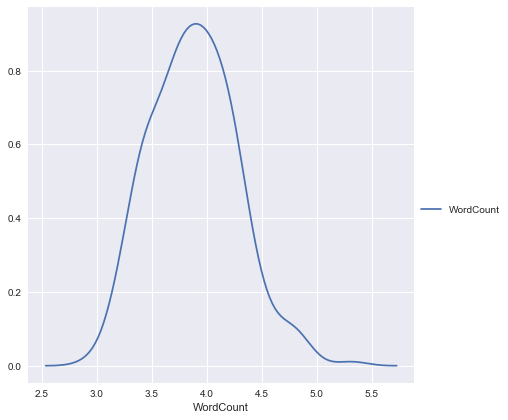

In [135]:
sns.FacetGrid(UserDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

## 2.6 Products Analysis

In this section we would be analysing the reviews based on product details so we would be adding a few new terminologies :- <br>
<b>Negativity</b> - It is a measure to see if Negative Reviews are more than Positive Reviews<br>
<b>DegreeOfPositivity</b> - It is a measure of the Number of Positive Reviews out of the Total Number Of Reviews given by a user  
<b>FrequentReviewedProduct</b> - Is a product which has received more than 50 reviews. There are 838 such products out of the 65442 unique products.

In [25]:
ProductDetails = pd.read_sql_query("""
SELECT COUNT(ProductId) AS NumberOfReviews , ProductId, SUM(Score='positive') AS PositiveReviews,SUM(Score='negative') AS NegetiveReviews,COUNT(UserId)>50 AS FrequentReviewedProduct,AVG(WordCount) AS WordsUsed,AVG(HelpfulnessNumerator/HelpfulnessDenominator)*100 AS HelpfulnessDegree,SUM(Score='negative')>SUM(Score='positive') AS Negativity
FROM Reviews 
GROUP BY ProductId 
ORDER BY NumberOfReviews desc
""", conn)
ProductDetails['DegreeOfPositivity']=ProductDetails['PositiveReviews']*1.0/ProductDetails['NumberOfReviews']*1.0
ProductDetails[:5]

,NumberOfReviews,ProductId,PositiveReviews,NegetiveReviews,FrequentReviewedProduct,WordsUsed,HelpfulnessDegree,Negativity,DegreeOfPositivity
0,856,B007JFMH8M,840,16,1,24.163551,85.185185,0,0.981308
1,609,B0026RQTGE,571,38,1,28.635468,68.944099,0,0.937603
2,598,B003B3OOPA,585,13,1,43.814381,78.554779,0,0.978261
3,551,B001EO5Q64,538,13,1,46.246824,77.419355,0,0.976407
4,532,B000NMJWZO,527,5,1,35.056391,86.559140,0,0.990602


In [ ]:
ProductDetails = pd.read_sql_query("""
SELECT COUNT(ProductId) AS NumberOfProductReviews , ProductId, SUM(Score='positive') AS PositiveReviews,COUNT(UserId)>50 AS FrequentReviewedProduct
FROM Reviews 
GROUP BY ProductId 
ORDER BY FrequentReviewedProduct desc
""", conn)
ProductDetails['DegreeOfPositivity']=ProductDetails['PositiveReviews']*1.0/ProductDetails['NumberOfProductReviews']*1.0
ProductDetails[:5]

In [ ]:
del ProductDetails['PositiveReviews']

In [ ]:
ProductDetails[:5]

In [ ]:
conn = sqlite3.connect('errors.sqlite')
c=conn.cursor()
conn.text_factory = str
ProductDetails.to_sql('Products', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [192]:
ProductDetails = ProductDetails[np.isfinite(ProductDetails['HelpfulnessDegree'])]

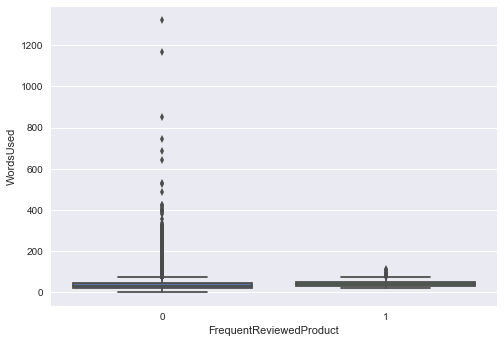

In [193]:
import seaborn as sns
sns.boxplot(x='FrequentReviewedProduct',y='WordsUsed', data=ProductDetails)
plt.show()

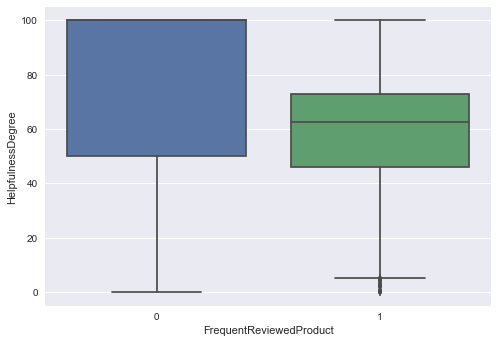

In [194]:
import seaborn as sns

sns.boxplot(x='FrequentReviewedProduct',y='HelpfulnessDegree', data=ProductDetails)
plt.show()

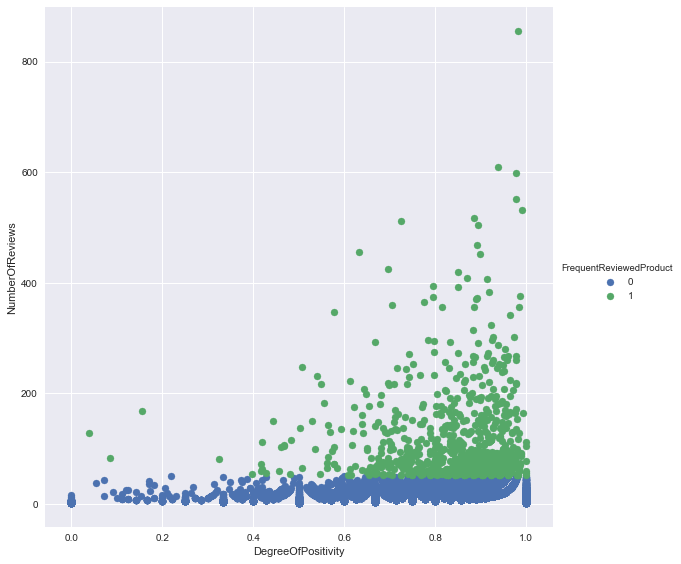

In [216]:
sns.FacetGrid(ProductDetails, hue="FrequentReviewedProduct", size=8) \
   .map(plt.scatter, "DegreeOfPositivity", "NumberOfReviews") \
   .add_legend();
plt.show();

<b>Observation:-</b> From the above graph it is clear that frequently reviewed products are generally given more positive reviews

In [220]:
ProductDetails = pd.read_sql_query("""
SELECT WordCount
FROM Reviews
WHERE ProductId="B007JFMH8M"
""", conn)

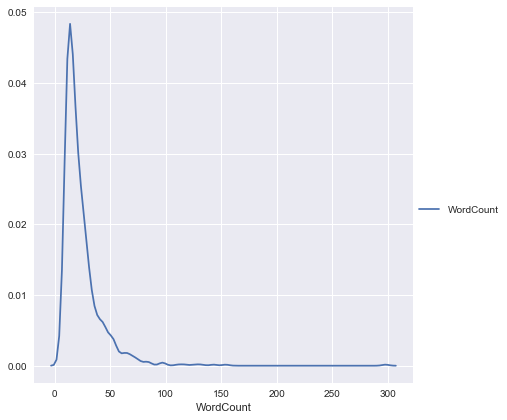

In [221]:
sns.FacetGrid(ProductDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

<b>Observation:-</b> The WordCount distribution for Frequently Reviewed products were taken and it was observed that it is log-normally distributed hence applied log to all the values to transform the distribution into normal distribution.

In [222]:
ProductDetails['WordCount']=ProductDetails[ProductDetails.WordCount>0]
ProductDetails.WordCount = ProductDetails.WordCount.astype(float)
ProductDetails['WordCount']=ProductDetails['WordCount'].apply(lambda i: math.log(i))

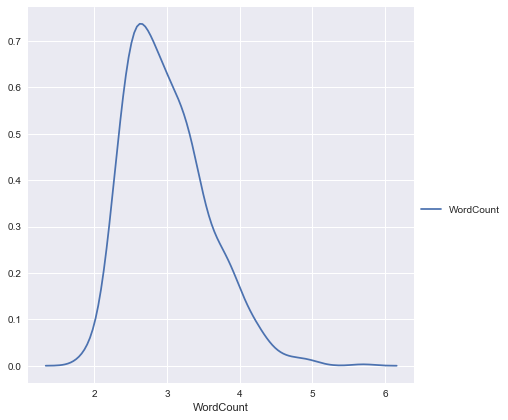

In [223]:
sns.FacetGrid(ProductDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

# 3. Predicting Models

Now after we have done a lot of exploratory data analysis we will now be focusing on delving deep into optimization and choosing of the right model for prediction of reviews to be positive or negative.<br><br>
The approach folowed will be to try all different variations in our first-cut model and then narrowing down and going deeper into optimization to acheive the best results

## 3.1 Featurizations

Among the various featurizations possible for text data we would be comparing amongst the following to see which of them gives us the best results <br>

Before we start we need to make sure that we separate our train and test corpus and hence it was decided to do a 70%-30% split after sorting the reviews based on the time they were cast. So we would be using the corpus of reviews cast before to to predict the sentiment of the future reviews

We will first be initializing the various featurizations that we will be using in our analysis (the same way s global variables are initialised before the functions of the program)

In [18]:
#sorting the dataset on basis of time in ascending order
final.sort_values('Time', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
train_corpus=(final['CleanedText'].values)[:255000]
test_corpus=(final['CleanedText'].values)[255000:]

In [19]:
y_train=(final['Score'].values)[:255000]
y_test=(final['Score'].values)[255000:]

1.Bag-of-words

In [83]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_corpus)
X_test_counts = count_vect.transform(test_corpus)

2.Tf-Idf

In [149]:
tf_idf_vect = TfidfVectorizer()
X_train_tfidf = tf_idf_vect.fit_transform(train_corpus)
X_test_tfidf = tf_idf_vect.transform(test_corpus)

3.Word2Vec

In [235]:
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower().encode('utf8'))
                else:
                    continue
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [236]:
w2v_features=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [39]:
all_word_vectors_matrix = w2v_features.wv.syn0
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_word_vectors_matrix[:5000])

3.1. Visualizing Word2Vec

In [41]:
words=[]
for i in range(5000):
    your_word_vector = all_word_vectors_matrix[i]
    a=w2v_features.most_similar(positive=[your_word_vector], topn=1)
    words.append(str(a[0][0]))
x = [i[1] for i in tsne_results ]
y = [i[0] for i in tsne_results ]

In [42]:
points = pd.DataFrame()
points['word']=words
points['x']=x
points['y']=y

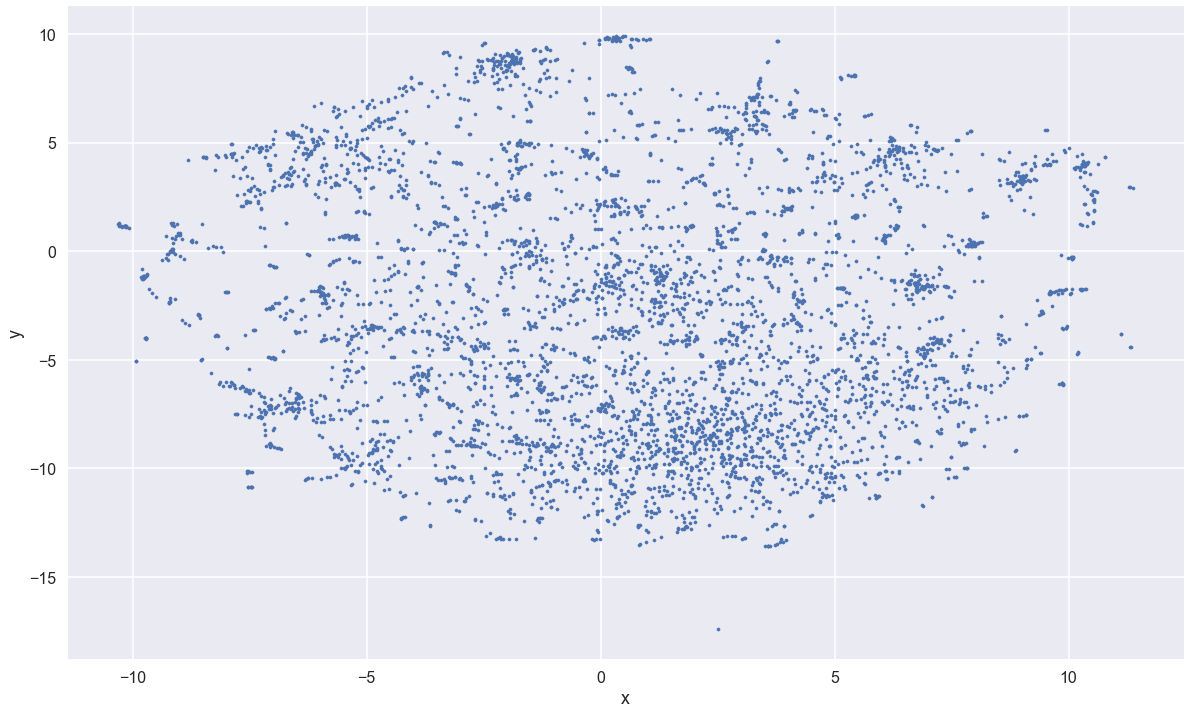

In [45]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

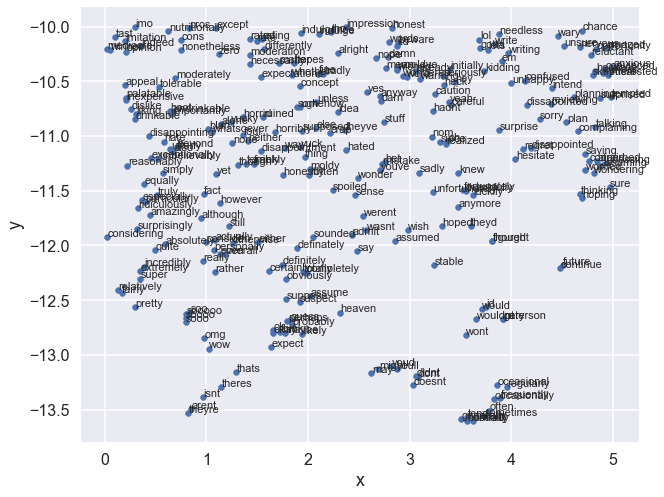

In [52]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
plot_region(x_bounds=(0, 5), y_bounds=(-15, -10))

In [54]:
w2v_features.most_similar("assumed")

[('thought', 0.6974591016769409),
 ('assume', 0.6818891167640686),
 ('guessed', 0.666894257068634),
 ('hoped', 0.6518867611885071),
 ('wondered', 0.6320422887802124),
 ('believed', 0.587792158126831),
 ('figured', 0.5867268443107605),
 ('feared', 0.5822019577026367),
 ('classify', 0.5730583071708679),
 ('knew', 0.5682975053787231)]

3.2. Making a vector for every review from word vectors

In [237]:
i=0
final_string=[]
featuresets=[]
for sent in final['Text'].values:
    i=0
    sum=0
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower().encode('utf8'))
                    i+=1
                    try:
                        sum+=w2v_features[cleaned_words.lower().encode('utf8')]
                    except:
                        i-=1
                        pass
                else:
                    continue
            else:
                continue        
    featuresets.append(sum/i)
    str1 = ' '.join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)

In [238]:
X_train_w2v=featuresets[:255000]
X_test_w2v=featuresets[255000:]

4.Tf-Idf Word2Vec

In [251]:
tfidf_vect_w2v = TfidfVectorizer()
X=tfidf_vect_w2v.fit_transform(final_string[:255000])
Y=tfidf_vect_w2v.transform(final_string[255000:])

4.1. Training set of Tf-Idf Review vectors

In [252]:
i=0
ind=0
sum=0
featuresets=[]
for sent in (final['Text'].values)[:255000]:
    i=0
    sum=0
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha() & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    try:
                        i+=X[ind, tfidf_vect_w2v.vocabulary_[cleaned_words.lower()]]
                        sum+=(w2v_features[cleaned_words.lower()]*X[ind, tfidf_vect_w2v.vocabulary_[cleaned_words.lower()]])
                    except:
                        try:
                            i-=X[ind, tfidf_vect_w2v.vocabulary_[cleaned_words.lower()]]
                        except:
                            pass
                    pass
                else:
                    continue
            else:
                continue 
    ind+=1
    featuresets.append(sum/i)

4.2. Test set of Tf-Idf Review Vectors

In [253]:
i=0
ind=0
sum=0
for sent in (final['Text'].values)[255000:]:
    i=0
    sum=0
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha() & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    try:
                        i+=Y[ind, tfidf_vect_w2v.vocabulary_[cleaned_words.lower()]]
                        sum+=(w2v_features[cleaned_words.lower()]*Y[ind, tfidf_vect_w2v.vocabulary_[cleaned_words.lower()]])
                    except:
                        try:
                            i-=Y[ind, tfidf_vect_w2v.vocabulary_[cleaned_words.lower()]]
                        except:
                            pass
                    pass
                else:
                    continue
            else:
                continue 
    ind+=1
    featuresets.append(sum/i)

In [254]:
X_train_w2v_tf_idf=featuresets[:255000]
X_test_w2v_tf_idf=featuresets[255000:]

5.Word2Vec with Stemming

In [262]:
cleaned=[i.split() for i in final['CleanedText'].values]
w2v_features_stemmed=gensim.models.Word2Vec(cleaned,min_count=5,size=100, workers=4)

5.1. Making a vector for every review from word vectors

In [263]:
i=0
list_of_sent=[]
sum=0
ind=0
featuresets=[]
for sent in final['CleanedText'].values:
    i=0
    sum=0
    for w in sent.split():
        i+=1
        try:
            sum+=w2v_features_stemmed[w]
        except:
            i-=1
            pass
    featuresets.append(sum/i)

In [264]:
X_train_w2v_stemmed=featuresets[:255000]
X_test_w2v_stemmed=featuresets[255000:]

6.Tf-Idf Word2Vec

6.1. Train set of Tf-Idf Review vectors

In [273]:
i=0
list_of_sent=[]
sum=0
ind=0
featuresets=[]
for sent in (final['CleanedText'].values)[:255000]:
    i=0
    sum=0
    for w in sent.split():
        try:
            i+=X_train_tfidf[ind, tf_idf_vect.vocabulary_[w]]
            sum+=(w2v_features_stemmed[w]*X_train_tfidf[ind, tf_idf_vect.vocabulary_[w]])
        except:
            try:
                i-=X_train_tfidf[ind, tf_idf_vect.vocabulary_[w]]
            except:
                pass
        pass
    ind+=1
    if i>0:
        featuresets.append(sum/i)
    else:
        print ind

6.2. Test set of Tf-Idf Review vectors

In [274]:
i=0
list_of_sent=[]
sum=0
ind=0
for sent in (final['CleanedText'].values)[255000:]:
    i=0
    sum=0
    for w in sent.split():
        try:
            i+=X_test_tfidf[ind, tf_idf_vect.vocabulary_[w]]
            sum+=(w2v_features_stemmed[w]*X_test_tfidf[ind, tf_idf_vect.vocabulary_[w]])
        except:
            try:
                i-=X_test_tfidf[ind, tf_idf_vect.vocabulary_[w]]
            except:
                pass
        pass
    ind+=1
    if i>0:
        featuresets.append(sum/i)
    else:
        print ind

In [275]:
X_train_w2v_tf_idf_stemmed=featuresets[:255000]
X_test_w2v_tf_idf_stemmed=featuresets[255000:]

## First-Cut Models

Now that we have our featurizations ready we can plug them into various different models and then narrow down by optimising and choosing the best among all the different models tested

One important thing before we start to test our models is that we need to define an error metric, which will help us choose the best model and optimise the models by letting know of the method tried out is working in our favour or no.

We are using the Macro-Averaged F1-Score metric to help us do the above as
- log-loss and other mean-square error metrics help us know how well is the model classifying points, but here the objective is to predict the right sentiment and it does not matter if it is even a loose prediction
- roc_auc is not used as it does not serve as a good metric to help us distinguish between our models as the first cut solution itself has an roc_auc_score of 0.95

We are using macro averaged f1-score so as to provide higher weightage to the minority class

Our First-Cut Solutions will be trying different learning methods and see how they fare for the dataset

In [203]:
f1_score_train={}
f1_score_test={}

## Logistic Regression

In [204]:
from sklearn import linear_model
lr_count = linear_model.LogisticRegression(C=0.1).fit(X_train_counts, y_train)

In [205]:
from sklearn.metrics import confusion_matrix
y_pred = lr_count.predict(X_test_counts)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[87632,  2467],
       [ 6851, 12217]])

In [206]:
from sklearn.metrics import f1_score
f1_score_test['lr_count']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.83      0.64      0.72     19068
   positive       0.93      0.97      0.95     90099

avg / total       0.91      0.91      0.91    109167



In [207]:
y_pred = lr_count.predict(X_train_counts)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[212928,   4030],
       [ 13100,  24942]])

In [208]:
f1_score_train['lr_count']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train, y_pred))

             precision    recall  f1-score   support

   negative       0.86      0.66      0.74     38042
   positive       0.94      0.98      0.96    216958

avg / total       0.93      0.93      0.93    255000



## Multinomial Naive Bayes

In [209]:
from sklearn.naive_bayes import MultinomialNB
mnb_count = MultinomialNB().fit(X_train_counts, y_train)

In [210]:
y_pred = mnb_count.predict(X_test_counts)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[84687,  5412],
       [ 5993, 13075]])

In [211]:
f1_score_test['mnb_count']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.71      0.69      0.70     19068
   positive       0.93      0.94      0.94     90099

avg / total       0.89      0.90      0.89    109167



In [212]:
y_pred = mnb_count.predict(X_train_counts)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[205807,  11151],
       [ 11028,  27014]])

In [213]:
f1_score_train['mnb_count']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.71      0.71      0.71     38042
   positive       0.95      0.95      0.95    216958

avg / total       0.91      0.91      0.91    255000



## Linear SVM using SGDClassifier

<b>Training</b>

In [214]:
from sklearn import linear_model
lr_svm_count = linear_model.SGDClassifier(l1_ratio=0).fit(X_train_counts, y_train)

<b>Evaluation Metrics</b>

In [215]:
y_pred=lr_svm_count.predict(X_test_counts)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[87121,  2978],
       [ 6636, 12432]])

In [216]:
f1_score_test['svm_count']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.81      0.65      0.72     19068
   positive       0.93      0.97      0.95     90099

avg / total       0.91      0.91      0.91    109167



In [217]:
y_pred=lr_svm_count.predict(X_train_counts)
f1_score_train['svm_count']=f1_score(y_train,y_pred,average='macro')
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[211861,   5097],
       [ 12622,  25420]])

In [218]:
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.83      0.67      0.74     38042
   positive       0.94      0.98      0.96    216958

avg / total       0.93      0.93      0.93    255000



##  Comparison Between our First-Cut Models

So after running our basic models with count-vectors following are the scores obtained. Before we choose a model to further work upon and optimise we need to keep in mind some real-world constraints
- Data we are dealing with is Amazon Fine Food Reviews which in the real-world scenario would be of incremental nature i.e. the number of reviews received would keep changing hence we need models too that accomodate this therefore we cannot use SVM  as it is difficult to do incremental learning in an SVM.
- As the data is of incremental nature the number of new words encountered by it would also increase hence fatures would increase therefore Tree-based Methods and SVM would not be a good choice.

We therefore have to now choose between Naive-Bayes and Logisitic Regression, between them Naive-bayes does not work well when the data is corellated and generally works well only for small datasets on the oher hand Logistic Regression works well on fairly large datasets too and even can handle some level of collinearity. Hence we go with Logisitic Regression further

In [219]:
print "Error Metric Matrix - F1 Score - Macro Averaged"
print "Logistic Regression -    Train: ",f1_score_train['lr_count'],"     Test: ",f1_score_test['lr_count']
print "Multinomial NaiveBayes - Train: ",f1_score_train['mnb_count'],"     Test: ",f1_score_test['mnb_count']
print "Linear SVM -             Train: ",f1_score_train['svm_count'],"     Test: ",f1_score_test['svm_count']

Error Metric Matrix - F1 Score - Macro Averaged
Logistic Regression -    Train:  0.852856188679      Test:  0.836722921102
Multinomial NaiveBayes - Train:  0.828917835441      Test:  0.816611997851
Linear SVM -             Train:  0.850706036738      Test:  0.834432298065


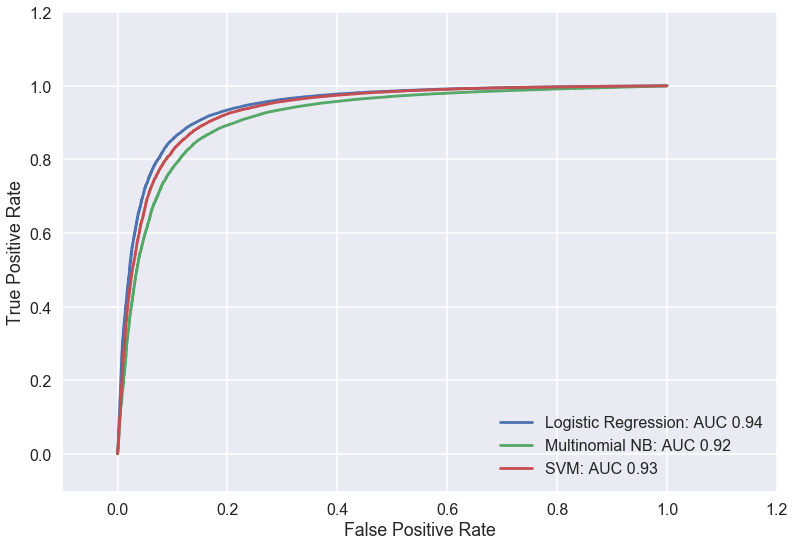

In [152]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,[j for i,j in lr_count.predict_proba(X_test_counts)],pos_label='positive')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s: AUC %0.2f'% ('Logistic Regression',roc_auc))
fpr, tpr, thresholds = metrics.roc_curve(y_test,[j for i,j in mnb_count.predict_proba(X_test_counts)],pos_label='positive')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s: AUC %0.2f'% ('Multinomial NB',roc_auc))
fpr, tpr, thresholds = metrics.roc_curve(y_test,lr_svm_count.decision_function(X_test_counts),pos_label='positive')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s: AUC %0.2f'% ('SVM',roc_auc))
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

##  Trying different variations of featurizations

Now that we have narrowed down to one model on the basis of real-world constraints lets try different featurizations to bring out its essence

Below we will be trying Logistic Regression with all the featurizations initialised in the beginning

In [224]:
lr_tfidf = linear_model.LogisticRegression(C=0.1).fit(X_train_tfidf, y_train)

In [225]:
y_pred=lr_tfidf.predict(X_test_tfidf)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[88891,  1208],
       [ 9726,  9342]])

In [226]:
f1_score_test['lr_tfidf']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.89      0.49      0.63     19068
   positive       0.90      0.99      0.94     90099

avg / total       0.90      0.90      0.89    109167



In [227]:
y_pred=lr_tfidf.predict(X_train_tfidf)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[214579,   2379],
       [ 19763,  18279]])

In [228]:
f1_score_train['lr_tfidf']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.88      0.48      0.62     38042
   positive       0.92      0.99      0.95    216958

avg / total       0.91      0.91      0.90    255000



In [295]:
lr_w2v = linear_model.LogisticRegression(C=1).fit(X_train_w2v, y_train)

In [296]:
y_pred=lr_w2v.predict(X_test_w2v)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[87357,  2742],
       [ 7801, 11267]])

In [241]:
f1_score_test['lr_w2v']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.80      0.59      0.68     19068
   positive       0.92      0.97      0.94     90099

avg / total       0.90      0.90      0.90    109167



In [242]:
y_pred=lr_w2v.predict(X_train_w2v)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[210745,   6213],
       [ 16135,  21907]])

In [243]:
f1_score_train['lr_w2v']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.78      0.58      0.66     38042
   positive       0.93      0.97      0.95    216958

avg / total       0.91      0.91      0.91    255000



In [478]:
from sklearn.ensemble import RandomForestClassifier
rnd_w2v = RandomForestClassifier()
rnd_w2v.fit(X_train_w2v, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [479]:
y_pred=rnd_w2v.predict(X_test_w2v)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[86378,  3721],
       [ 9919,  9149]])

In [480]:
f1_score_test['rnd_w2v']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.71      0.48      0.57     19068
   positive       0.90      0.96      0.93     90099

avg / total       0.86      0.88      0.87    109167



In [481]:
y_pred=rnd_w2v.predict(X_train_w2v)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[216690,    268],
       [   698,  37344]])

In [482]:
f1_score_train['rnd_w2v']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.99      0.98      0.99     38042
   positive       1.00      1.00      1.00    216958

avg / total       1.00      1.00      1.00    255000



In [255]:
lr_w2v_tfidf = linear_model.LogisticRegression(C=1).fit(X_train_w2v_tf_idf, y_train)

In [256]:
y_pred=lr_w2v_tfidf.predict(X_test_w2v_tf_idf)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[87277,  2822],
       [ 9139,  9929]])

In [257]:
f1_score_test['lr_w2v_tfidf']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.78      0.52      0.62     19068
   positive       0.91      0.97      0.94     90099

avg / total       0.88      0.89      0.88    109167



In [258]:
y_pred=lr_w2v_tfidf.predict(X_train_w2v_tf_idf)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[210676,   6282],
       [ 18760,  19282]])

In [259]:
f1_score_train['lr_w2v_tfidf']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.75      0.51      0.61     38042
   positive       0.92      0.97      0.94    216958

avg / total       0.89      0.90      0.89    255000



In [265]:
lr_w2v_stemmed = linear_model.LogisticRegression(C=1).fit(X_train_w2v_stemmed, y_train)

In [266]:
y_pred=lr_w2v_stemmed.predict(X_test_w2v_stemmed)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[87332,  2767],
       [ 8088, 10980]])

In [267]:
f1_score_test['lr_w2v_stemmed']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.80      0.58      0.67     19068
   positive       0.92      0.97      0.94     90099

avg / total       0.89      0.90      0.89    109167



In [269]:
y_pred=lr_w2v_stemmed.predict(X_train_w2v_stemmed)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[210698,   6260],
       [ 16584,  21458]])

In [270]:
f1_score_train['lr_w2v_stemmed']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.77      0.56      0.65     38042
   positive       0.93      0.97      0.95    216958

avg / total       0.90      0.91      0.90    255000



In [276]:
lr_w2v_tfidf_stemmed = linear_model.LogisticRegression(C=1).fit(X_train_w2v_tf_idf_stemmed, y_train)

In [277]:
y_pred=lr_w2v_tfidf_stemmed.predict(X_test_w2v_tf_idf_stemmed)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[87317,  2782],
       [ 9775,  9293]])

In [278]:
f1_score_test['lr_w2v_tfidf_stemmed']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.77      0.49      0.60     19068
   positive       0.90      0.97      0.93     90099

avg / total       0.88      0.88      0.87    109167



In [279]:
y_pred=lr_w2v_tfidf_stemmed.predict(X_train_w2v_tf_idf_stemmed)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[210627,   6331],
       [ 19847,  18195]])

In [280]:
f1_score_train['lr_w2v_tfidf_stemmed']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.74      0.48      0.58     38042
   positive       0.91      0.97      0.94    216958

avg / total       0.89      0.90      0.89    255000



## Comparison between different featurizations

After performing various featurizations we could conclude-
- Count-Vector featurization works best until now
- The performance of word2vec is degraded on using techniques like stemming and tf-idf word2vec for the dataset

Hence from we will only be focusing on Word2Vec and will discard tf-idf word2vec from further analysis

In [485]:
print "Error Metric Matrix - F1 Score - Macro Averaged"
print "Logistic Regression (Counts) -             Train: ",f1_score_train['lr_count'],"     Test: ",f1_score_test['lr_count']
print "Logistic Regression (Tf-Idf) -             Train: ",f1_score_train['lr_tfidf'],"     Test: ",f1_score_test['lr_tfidf']
print "Logistic Regression (W2V) -                Train: ",f1_score_train['lr_w2v'],"     Test: ",f1_score_test['lr_w2v']
print "Logistic Regression (W2V-Stemmed) -        Train: ",f1_score_train['lr_w2v_stemmed'],"     Test: ",f1_score_test['lr_w2v_stemmed']
print "Logistic Regression (Tf-Idf-W2V) -         Train: ",f1_score_train['lr_w2v_tfidf'],"     Test: ",f1_score_test['lr_w2v_tfidf']
print "Logistic Regression (Tf-Idf-W2V-Stemmed) - Train: ",f1_score_train['lr_w2v_tfidf_stemmed'],"     Test: ",f1_score_test['lr_w2v_tfidf_stemmed']
print "Random Forest (W2V) -                      Train: ",f1_score_train['rnd_w2v'],"     Test: ",f1_score_test['rnd_w2v']


Error Metric Matrix - F1 Score - Macro Averaged
Logistic Regression (Counts) -             Train:  0.852856188679      Test:  0.836722921102
Logistic Regression (Tf-Idf) -             Train:  0.786865579694      Test:  0.786446844148
Logistic Regression (W2V) -                Train:  0.805935661712      Test:  0.812174375271
Logistic Regression (W2V-Stemmed) -        Train:  0.800596458678      Test:  0.8053473143
Logistic Regression (Tf-Idf-W2V) -         Train:  0.775098289677      Test:  0.779981816449
Logistic Regression (Tf-Idf-W2V-Stemmed) - Train:  0.761549998425      Test:  0.764857105516
Random Forest (W2V) -                      Train:  0.992503654659      Test:  0.749872500709


## Tuning parameters - Class-Weights

From the observations in the previous section we could see that our predictions are quite biased towards the positive side hence the idea of using class_weights.

In [299]:
lr_count_cw = linear_model.LogisticRegression(C=0.1,class_weight={'positive':1,'negative':3}).fit(X_train_counts, y_train)

In [300]:
y_pred=lr_count_cw.predict(X_test_counts)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[83862,  6237],
       [ 3703, 15365]])

In [301]:
f1_score_test['lr_count_cw']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.71      0.81      0.76     19068
   positive       0.96      0.93      0.94     90099

avg / total       0.91      0.91      0.91    109167



In [302]:
y_pred=lr_count_cw.predict(X_train_counts)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[205002,  11956],
       [  6235,  31807]])

In [303]:
f1_score_train['lr_count_cw']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.73      0.84      0.78     38042
   positive       0.97      0.94      0.96    216958

avg / total       0.93      0.93      0.93    255000



In [304]:
lr_tfidf_cw = linear_model.LogisticRegression(C=0.1,class_weight={'positive':1,'negative':3}).fit(X_train_tfidf, y_train)

In [305]:
y_pred=lr_tfidf_cw.predict(X_test_tfidf)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[83844,  6255],
       [ 3888, 15180]])

In [306]:
f1_score_test['lr_tfidf_cw']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.71      0.80      0.75     19068
   positive       0.96      0.93      0.94     90099

avg / total       0.91      0.91      0.91    109167



In [307]:
y_pred=lr_tfidf_cw.predict(X_train_tfidf)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[204060,  12898],
       [  7868,  30174]])

In [308]:
f1_score_train['lr_tfidf_cw']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.70      0.79      0.74     38042
   positive       0.96      0.94      0.95    216958

avg / total       0.92      0.92      0.92    255000



In [309]:
lr_w2v_cw = linear_model.LogisticRegression(C=1,class_weight={'positive':1,'negative':3}).fit(X_train_w2v, y_train)

In [310]:
y_pred=lr_w2v_cw.predict(X_test_w2v)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[81879,  8220],
       [ 4042, 15026]])

In [311]:
f1_score_test['lr_w2v_cw']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.65      0.79      0.71     19068
   positive       0.95      0.91      0.93     90099

avg / total       0.90      0.89      0.89    109167



In [312]:
y_pred=lr_w2v_cw.predict(X_train_w2v)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[198458,  18500],
       [  8309,  29733]])

In [313]:
f1_score_train['lr_w2v_cw']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.62      0.78      0.69     38042
   positive       0.96      0.91      0.94    216958

avg / total       0.91      0.89      0.90    255000



In [314]:
lr_w2v_stemmed_cw = linear_model.LogisticRegression(C=1,class_weight={'positive':1,'negative':3}).fit(X_train_w2v_stemmed, y_train)

In [315]:
y_pred=lr_w2v_stemmed_cw.predict(X_test_w2v_stemmed)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[81740,  8359],
       [ 4135, 14933]])

In [316]:
f1_score_test['lr_w2v_cw_stemmed']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.64      0.78      0.71     19068
   positive       0.95      0.91      0.93     90099

avg / total       0.90      0.89      0.89    109167



In [317]:
y_pred=lr_w2v_stemmed_cw.predict(X_train_w2v_stemmed)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[198033,  18925],
       [  8604,  29438]])

In [318]:
f1_score_train['lr_w2v_cw_stemmed']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.61      0.77      0.68     38042
   positive       0.96      0.91      0.94    216958

avg / total       0.91      0.89      0.90    255000



## Comparison after inducing class-weights

Adding class-weights has certainly improved our model and has increased the accuracy of the negative class

In [319]:
print "Error Metric Matrix - F1 Score - Macro Averaged"
print "Logistic Regression (Counts) -             Train: ",f1_score_train['lr_count_cw'],"     Test: ",f1_score_test['lr_count_cw']
print "Logistic Regression (Tf-Idf) -             Train: ",f1_score_train['lr_tfidf_cw'],"     Test: ",f1_score_test['lr_tfidf_cw']
print "Logistic Regression (W2V) -                Train: ",f1_score_train['lr_w2v_cw'],"     Test: ",f1_score_test['lr_w2v_cw']
print "Logistic Regression (W2V-Stemmed) -        Train: ",f1_score_train['lr_w2v_cw_stemmed'],"     Test: ",f1_score_test['lr_w2v_cw_stemmed']

Error Metric Matrix - F1 Score - Macro Averaged
Logistic Regression (Counts) -             Train:  0.867573374175      Test:  0.849822748435
Logistic Regression (Tf-Idf) -             Train:  0.847785739617      Test:  0.846268403082
Logistic Regression (W2V) -                Train:  0.812995637158      Test:  0.820275787592
Logistic Regression (W2V-Stemmed) -        Train:  0.808203394523      Test:  0.817026405459


## Adding more features

Now that we have reduced the gap between the positive and negative precision, recall scores we would now require to increase variance as our test and our train set have nearly equal error values hence we do so by adding more features

Bigrams for Tf-Idf and Count featurizations and larger vector size for word2vec

In [324]:
bigram_count_vect = CountVectorizer(ngram_range=(1, 2))
X_train_bigram_counts = bigram_count_vect.fit_transform(train_corpus)
X_test_bigram_counts = bigram_count_vect.transform(test_corpus)

In [327]:
lr_count_bigram = linear_model.LogisticRegression(C=100,class_weight={'positive':1,'negative':3}).fit(X_train_bigram_counts, y_train)

In [328]:
y_pred=lr_count_bigram.predict(X_test_bigram_counts)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[86842,  3257],
       [ 4437, 14631]])

In [329]:
f1_score_test['lr_count_bigram']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.82      0.77      0.79     19068
   positive       0.95      0.96      0.96     90099

avg / total       0.93      0.93      0.93    109167



In [330]:
y_pred=lr_count_bigram.predict(X_train_bigram_counts)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[216952,      6],
       [     1,  38041]])

In [331]:
f1_score_train['lr_count_bigram']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       1.00      1.00      1.00     38042
   positive       1.00      1.00      1.00    216958

avg / total       1.00      1.00      1.00    255000



In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
bigram_tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2))
X_train_bigram_tfidf = bigram_tf_idf_vect.fit_transform(train_corpus)
X_test_bigram_tfidf = bigram_tf_idf_vect.transform(test_corpus)

In [25]:
from sklearn import linear_model
lr_tfidf_bigram = linear_model.LogisticRegression(C=100,class_weight={'positive':1,'negative':3}).fit(X_train_bigram_tfidf, y_train)

In [334]:
y_pred=lr_tfidf_bigram.predict(X_test_bigram_tfidf)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[87006,  3093],
       [ 4273, 14795]])

In [335]:
f1_score_test['lr_tfidf_bigram']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.83      0.78      0.80     19068
   positive       0.95      0.97      0.96     90099

avg / total       0.93      0.93      0.93    109167



In [336]:
y_pred=lr_tfidf_bigram.predict(X_train_bigram_tfidf)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[216950,      8],
       [     0,  38042]])

In [337]:
f1_score_train['lr_tfidf_bigram']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       1.00      1.00      1.00     38042
   positive       1.00      1.00      1.00    216958

avg / total       1.00      1.00      1.00    255000



In [340]:
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower().encode('utf8'))
                else:
                    continue
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [341]:
w2v_more_features=gensim.models.Word2Vec(list_of_sent,min_count=5,size=200, workers=4)

In [342]:
i=0
final_string=[]
featuresets=[]
for sent in final['Text'].values:
    i=0
    sum=0
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower().encode('utf8'))
                    i+=1
                    try:
                        sum+=w2v_more_features[cleaned_words.lower().encode('utf8')]
                    except:
                        i-=1
                        pass
                else:
                    continue
            else:
                continue        
    featuresets.append(sum/i)
    str1 = ' '.join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)

In [343]:
X_train_w2v_200=featuresets[:255000]
X_test_w2v_200=featuresets[255000:]

In [353]:
lr_w2v_200 = linear_model.LogisticRegression(C=10,class_weight={'positive':1,'negative':3}).fit(X_train_w2v_200, y_train)

In [354]:
y_pred=lr_w2v_200.predict(X_test_w2v_200)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[82414,  7685],
       [ 3767, 15301]])

In [355]:
f1_score_test['lr_w2v_200']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.67      0.80      0.73     19068
   positive       0.96      0.91      0.94     90099

avg / total       0.91      0.90      0.90    109167



In [356]:
y_pred=lr_w2v_200.predict(X_train_w2v_200)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[199795,  17163],
       [  7814,  30228]])

In [357]:
f1_score_train['lr_w2v_200']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.64      0.79      0.71     38042
   positive       0.96      0.92      0.94    216958

avg / total       0.91      0.90      0.91    255000



## Comaparison after adding more features

The best model after all this turned out to be Logistic Regression (Tf-Idf-Bigrams). But is it can be seen the difference between the train and test set error is quite high hence we have overfitted our data and are sufferering from high variance

In [363]:
print "Error Metric Matrix - F1 Score - Macro Averaged"
print "Logistic Regression (Counts-ClassWeights) -        Train: ",f1_score_train['lr_count_cw'],"     Test: ",f1_score_test['lr_count_cw']
print "Logistic Regression (Tf-Idf-ClassWeights) -        Train: ",f1_score_train['lr_tfidf_cw'],"     Test: ",f1_score_test['lr_tfidf_cw']
print "Logistic Regression (W2V-ClassWeights) -           Train: ",f1_score_train['lr_w2v_cw'],"     Test: ",f1_score_test['lr_w2v_cw']
print "-----------------------------------------------------------------------------------------------------------"
print "Logistic Regression (Counts-Bigrams) -             Train: ",f1_score_train['lr_count_bigram'],"     Test: ",f1_score_test['lr_count_bigram']
print "Logistic Regression (Tf-Idf-Bigrams) -             Train: ",f1_score_train['lr_tfidf_bigram'],"     Test: ",f1_score_test['lr_tfidf_bigram']
print "Logistic Regression (W2V-Bigrams) -                Train: ",f1_score_train['lr_w2v_200'],"     Test: ",f1_score_test['lr_w2v_200']

Error Metric Matrix - F1 Score - Macro Averaged
Logistic Regression (Counts-ClassWeights) -        Train:  0.867573374175      Test:  0.849822748435
Logistic Regression (Tf-Idf-ClassWeights) -        Train:  0.847785739617      Test:  0.846268403082
Logistic Regression (W2V-ClassWeights) -           Train:  0.812995637158      Test:  0.820275787592
-----------------------------------------------------------------------------------------------------------
Logistic Regression (Counts-Bigrams) -             Train:  0.999945935065      Test:  0.874693387236
Logistic Regression (Tf-Idf-Bigrams) -             Train:  0.999938213512      Test:  0.880035285987
Logistic Regression (W2V-Bigrams) -                Train:  0.824406448741      Test:  0.831359312962


## Feature Selection

As we are suffering from high variance we need to reduce the number of features so as to reduce variance

L1-Regularization for sparsity

In [366]:
from sklearn.linear_model import LogisticRegression
l1_LR_10 = LogisticRegression(penalty='l1',C=10,class_weight={'positive':1,'negative':3})
l1_LR_100 = LogisticRegression(penalty='l1',C=100,class_weight={'positive':1,'negative':3})
l1_LR_10.fit(X_train_bigram_tfidf, y_train)
l1_LR_100.fit(X_train_bigram_tfidf, y_train)
coef_l1_LR_10 = l1_LR_10.coef_.ravel()
coef_l1_LR_100 = l1_LR_100.coef_.ravel()

In [367]:
vec=bigram_tf_idf_vect.get_feature_names()

In [369]:
num=0
j=0
final_features=[]
for i in coef_l1_LR_10:
    if i>0:
        num+=1
        final_features.append(vec[j])
    j+=1
print 'Number of features for C=10 = ',len(final_features)

num=0
j=0
final_features=[]
for i in coef_l1_LR_100:
    if i>0:
        num+=1
        final_features.append(vec[j])
    j+=1
print 'Number of features for C=100 = ',len(final_features)

Number of features for C=10 =  14581
Number of features for C=100 =  19383


In [371]:
sparse_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),vocabulary=final_features)
X_reduced_train = sparse_tf_idf_vect.fit_transform(train_corpus)
X_reduced_test = sparse_tf_idf_vect.transform(test_corpus)

In [439]:
lr_reduced = linear_model.LogisticRegression(C=1,class_weight={'positive':1,'negative':3}).fit(X_reduced_train, y_train)

In [440]:
y_pred=lr_reduced.predict(X_reduced_test)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[81004,  9095],
       [ 5288, 13780]])

In [441]:
f1_score_test['lr_reduced']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.60      0.72      0.66     19068
   positive       0.94      0.90      0.92     90099

avg / total       0.88      0.87      0.87    109167



In [442]:
y_pred=lr_reduced.predict(X_reduced_train)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[199159,  17799],
       [  8359,  29683]])

In [443]:
f1_score_train['lr_reduced']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.63      0.78      0.69     38042
   positive       0.96      0.92      0.94    216958

avg / total       0.91      0.90      0.90    255000



In [444]:
print "Logistic Regression (Tf-Idf-Bigrams) -             Train: ",f1_score_train['lr_tfidf_bigram'],"     Test: ",f1_score_test['lr_tfidf_bigram']
print "--------------------------------------------------------------------------------------------------------------------"
print "Logistic Regression (Tf-Idf-Bigrams-L1-Sparsity) - Train: ",f1_score_train['lr_reduced'],"     Test: ",f1_score_test['lr_reduced']

Logistic Regression (Tf-Idf-Bigrams) -             Train:  0.999938213512      Test:  0.880035285987
--------------------------------------------------------------------------------------------------------------------
Logistic Regression (Tf-Idf-Bigrams-L1-Sparsity) - Train:  0.816260059714      Test:  0.78777089462


L2 regularization and removing less-weighted terms

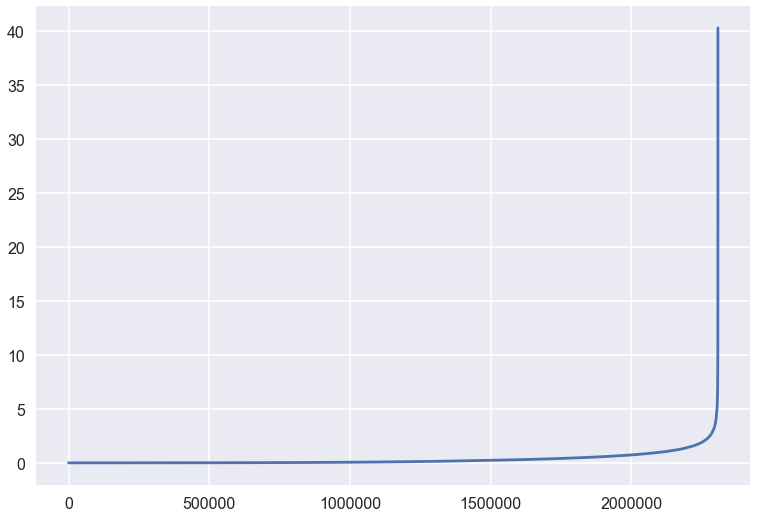

In [403]:
import seaborn as sns
coef_l2_LR_100 = lr_tfidf_bigram.coef_.ravel()
d = {}
coef_l2_LR_100=map(abs,coef_l2_LR_100)
d = dict(zip(vec, coef_l2_LR_100))
sorted_d=sorted(d.iteritems(), key=lambda (k,v): (v,k))
sns.set_style("darkgrid")
plt.plot([x[1] for x in sorted_d])
plt.show()

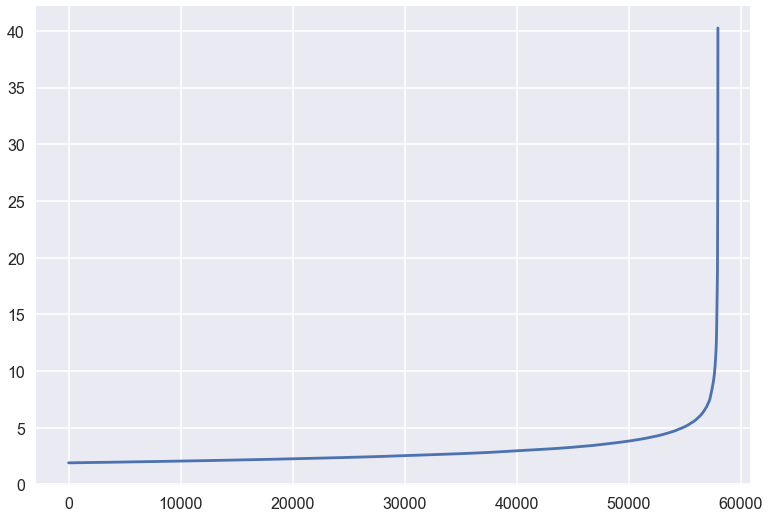

In [406]:
sns.set_style("darkgrid")
plt.plot(([x[1] for x in sorted_d])[2250000:])
plt.show()

In [461]:
final_words=([x[0] for x in sorted_d])[2250000:]

In [409]:
sparse_l2_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),vocabulary=final_words)
X_reduced_l2_train = sparse_l2_tf_idf_vect.fit_transform(train_corpus)
X_reduced_l2_test = sparse_l2_tf_idf_vect.transform(test_corpus)

In [419]:
lr_reduced_l2 = linear_model.LogisticRegression(C=1,class_weight={'positive':1,'negative':3}).fit(X_reduced_l2_train, y_train)

In [446]:
y_pred=lr_reduced_l2.predict(X_reduced_l2_test)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[86329,  3770],
       [16194,  2874]])

In [447]:
f1_score_test['lr_reduced_l2']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.43      0.15      0.22     19068
   positive       0.84      0.96      0.90     90099

avg / total       0.77      0.82      0.78    109167



In [448]:
y_pred=lr_reduced_l2.predict(X_reduced_l2_train)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[211485,   5473],
       [ 28344,   9698]])

In [449]:
f1_score_train['lr_reduced_l2']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.64      0.25      0.36     38042
   positive       0.88      0.97      0.93    216958

avg / total       0.85      0.87      0.84    255000



In [466]:
zero_index=0
for z in ([x[1] for x in sorted_d]):
    if z>0.1:
        break
    else:
        zero_index+=1
final_words=([x[0] for x in sorted_d])[zero_index:]
len(final_words)

1128877

In [467]:
sparse_l2_tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2),vocabulary=final_words)
X_reduced_l2_train2 = sparse_l2_tf_idf_vect2.fit_transform(train_corpus)
X_reduced_l2_test2 = sparse_l2_tf_idf_vect2.transform(test_corpus)

In [468]:
lr_reduced_l2_2 = linear_model.LogisticRegression(C=1,class_weight={'positive':1,'negative':3}).fit(X_reduced_l2_train2, y_train)

In [470]:
y_pred=lr_reduced_l2_2.predict(X_reduced_l2_test2)
cm=confusion_matrix(y_test,y_pred,labels=['positive','negative'])
cm

array([[84243,  5856],
       [ 5415, 13653]])

In [471]:
f1_score_test['lr_reduced_l2_2']=f1_score(y_test,y_pred,average='macro')
print(metrics.classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.70      0.72      0.71     19068
   positive       0.94      0.94      0.94     90099

avg / total       0.90      0.90      0.90    109167



In [472]:
y_pred=lr_reduced_l2_2.predict(X_reduced_l2_train2)
cm=confusion_matrix(y_train,y_pred,labels=['positive','negative'])
cm

array([[209634,   7324],
       [  4383,  33659]])

In [473]:
f1_score_train['lr_reduced_l2_2']=f1_score(y_train,y_pred,average='macro')
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

   negative       0.82      0.88      0.85     38042
   positive       0.98      0.97      0.97    216958

avg / total       0.96      0.95      0.95    255000



Reducing features is causing a hugehit on the performance as can be seen below

In [475]:
print "Logistic Regression (Tf-Idf-Bigrams) -                 Train: ",f1_score_train['lr_tfidf_bigram'],"     Test: ",f1_score_test['lr_tfidf_bigram']
print "--------------------------------------------------------------------------------------------------------------------"
print "Logistic Regression (Tf-Idf-Bigrams-L1-Sparsity) -     Train: ",f1_score_train['lr_reduced'],"     Test: ",f1_score_test['lr_reduced']
print "--------------------------------------------------------------------------------------------------------------------"
print "Logistic Regression (Tf-Idf-Bigrams-L2-Sparsity) -     Train: ",f1_score_train['lr_reduced_l2'],"      Test: ",f1_score_test['lr_reduced_l2']
print "Logistic Regression (Tf-Idf-Bigrams-L2-Less Sparse) -  Train: ",f1_score_train['lr_reduced_l2_2'],"     Test: ",f1_score_test['lr_reduced_l2_2']

Logistic Regression (Tf-Idf-Bigrams) -                 Train:  0.999938213512      Test:  0.880035285987
--------------------------------------------------------------------------------------------------------------------
Logistic Regression (Tf-Idf-Bigrams-L1-Sparsity) -     Train:  0.816260059714      Test:  0.78777089462
--------------------------------------------------------------------------------------------------------------------
Logistic Regression (Tf-Idf-Bigrams-L2-Sparsity) -     Train:  0.64523254011       Test:  0.559954899755
Logistic Regression (Tf-Idf-Bigrams-L2-Less Sparse) -  Train:  0.912346509323      Test:  0.822564888812


## Manual EDA of the errors

As the notion of reducing features is not working out good we will perform Manual data analysis of the errors to see if we could engineer any feature so as to reduce the gap between train and test error.

Based on our exploratory data analysis at the beginning we have two features
1. Degree of Positivity of Product & Users
2. Positive Probability of the Summary of the Review

In [26]:
error_db = pd.DataFrame()
error_db['Reviews']=test_corpus
error_db['WordCount']=error_db['Reviews'].values
error_db['WordCount'] = error_db['WordCount'].apply(lambda i: len(i.split()))
error_db['GroundTruth']=y_test
error_db['PredictedValue']=lr_tfidf_bigram.predict(X_test_bigram_tfidf)
probs=lr_tfidf_bigram.predict_proba(X_test_bigram_tfidf)
error_db['NegProb']= [x for x,y in probs]
error_db['PosProb']= [y for x,y in probs]
error_db['UserId']=(final['UserId'].values)[255000:]
error_db['ProductId']=(final['ProductId'].values)[255000:]
error_db[:5]

,Reviews,WordCount,GroundTruth,PredictedValue,NegProb,PosProb,UserId,ProductId
0,bought product help allerg yorkshir terrier wo...,94,positive,positive,1.650831e-01,0.834917,A23UHUA27I0RPU,B001B10WR8
1,bit skeptic saw altern origin tri fog chaser s...,32,positive,positive,1.618052e-07,1.000000,A1CPFS7FUNSTG1,B005ZBZLT4
2,kit nice work put last bag room carboy made pu...,21,positive,positive,7.235580e-04,0.999276,A2I1EMBCRV1E1K,B002RYY2YW
3,quit good mix flour cornbread wonder,6,positive,positive,1.841320e-05,0.999982,AYFEVLLR87D7E,B000KENKXA
4,love coffe decaf stronger cup coffe love would...,10,positive,positive,1.914074e-07,1.000000,A2JH5I74LDJUV2,B001D0IZBW


In [5]:
import sqlite3
conn = sqlite3.connect('testing.sqlite')

In [ ]:
c=conn.cursor()
conn.text_factory = str
error_db.to_sql('Errors', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [ ]:
ErrorDetails = pd.read_sql_query("""
SELECT Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NumberOfProductReviews AS NPR,FrequentReviewedProduct AS FRP,Products.DegreeOfPositivity AS DPP
FROM Errors,Products,Users
WHERE Errors.ProductId=Products.ProductId AND Errors.ProductId=Products.ProductId
ORDER BY PosProb desc
""", conn)
print "Number of Reviews that are not cast by any new user or for any new product = ",len(ErrorDetails)

In [29]:
#We also save this format of the final data along with the values in another SQLite table for easy querrying for analysis later
conn = sqlite3.connect('testing.sqlite')
c=conn.cursor()
conn.text_factory = str
ErrorDetails.to_sql('Test', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [8]:
ErrorDetails = pd.read_sql_query("""
SELECT *
FROM Test
WHERE GroundTruth!=PredictedValue AND PosProb<0.6 AND NegProb<0.6
ORDER BY NegProb asc
""", conn)
print"Number of Errors made in the Reviews in the borderline=",len(ErrorDetails)
ErrorDetails

Number of Errors made in the Reviews in the borderline= 588


,index,Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NUR,NPR,FRP,FR,DPP,DPU
0,17865,consum bewar greeni product dog cat contain to...,negative,positive,0.400003,0.599997,2,415,1,0,0.942169,1.000000
1,17866,get betti crocker serious much better less exp...,negative,positive,0.400035,0.599965,3,7,0,0,0.857143,1.000000
2,17880,adequ decaf lack signific defect also lack muc...,negative,positive,0.400709,0.599291,61,28,0,1,0.821429,0.901639
3,17881,pretti certain brand instant coffe better rece...,negative,positive,0.400764,0.599236,1,2,0,0,0.000000,1.000000
4,17899,disgust tini bittersweet tast gross aftertast ...,negative,positive,0.402008,0.597992,1,2,0,0,1.000000,1.000000
5,17907,hey chocol actual sens expect close contain ch...,negative,positive,0.402390,0.597610,19,1,0,0,0.000000,0.526316
6,17910,someth tast grandma coffe cake ive twice last ...,negative,positive,0.402550,0.597450,1,9,0,0,0.888889,0.000000
7,17927,love greek food excit find product posit revie...,negative,positive,0.403525,0.596475,10,15,0,0,0.800000,0.900000
8,17933,entir purpos product flavor water commerci mak...,negative,positive,0.403839,0.596161,3,175,1,0,0.822857,1.000000
9,17935,recent discov ginger beer like ginger ale spic...,negative,positive,0.403934,0.596066,1,2,0,0,1.000000,0.000000


In [43]:
ErrorDetails = pd.read_sql_query("""
SELECT *
FROM Test
WHERE GroundTruth='positive' AND PredictedValue='negative' AND NegProb<0.6 AND (DPP>0.78 AND DPU>0.78)
ORDER BY NegProb asc
""", conn)
print"Number of Errors corrected when NegProb<0.6 AND (DPP>0.78 AND DPU>0.78) = ",len(ErrorDetails)
ErrorDetails

Number of Errors corrected when NegProb<0.6 AND (DPP>0.78 AND DPU>0.78) =  285


,index,Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NUR,NPR,FRP,FR,DPP,DPU
0,18890,dri mango snack sweet chewi yummi certifi orga...,positive,negative,0.500023,0.499977,182,14,0,1,0.785714,1.000000
1,18892,use hot air popper popcorn trueli pure pop tas...,positive,negative,0.501078,0.498922,1,4,0,0,1.000000,1.000000
2,18893,fantast poke product add sesam oil green onion...,positive,negative,0.501165,0.498835,1,10,0,0,1.000000,1.000000
3,18896,delici blend grain isra couscous chick pea coo...,positive,negative,0.501316,0.498684,19,4,0,0,1.000000,0.842105
4,18897,coffe kind flavor certain better folger maxwel...,positive,negative,0.501468,0.498532,1,3,0,0,1.000000,1.000000
5,18898,never heard granola found big lot love peanut ...,positive,negative,0.501553,0.498447,22,11,0,0,0.909091,0.818182
6,18899,realli love peanut butter one sandwich worth p...,positive,negative,0.501599,0.498401,18,48,0,0,0.895833,1.000000
7,18900,dog love food first ingredi corn pleasur big b...,positive,negative,0.501604,0.498396,1,7,0,0,0.857143,1.000000
8,18901,isnt crystal light appletini refresh ad ice co...,positive,negative,0.501833,0.498167,11,141,1,0,0.900709,1.000000
9,18904,one cat food allergi vomit twice week vet sugg...,positive,negative,0.502371,0.497629,1,11,0,0,0.909091,1.000000


1. Anderson-Darling Test 
2. l1-sparsity class-weights?
3. How do we check if train-test are of same distribution?